In [205]:
import torch
import numpy as np
from dataset import Animal10
import torchvision.transforms as tf
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image

In [206]:
transforms = tf.Compose([
    tf.ToTensor(),
    tf.Resize((224,224)),
    # tf.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    tf.RandomHorizontalFlip(),
    # v2.CutMix(alpha=1,num_classes=10),
])

In [207]:
dataset = Animal10(False,transform=transforms)
data_loader = DataLoader(dataset, 4, True)
cut_mix = v2.CutMix(alpha=0.3, num_classes=10)

c:\Users\mg352\anaconda3\envs\ML_cuda2\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([0.0000, 0.0000, 0.5048, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4952,
        0.0000])


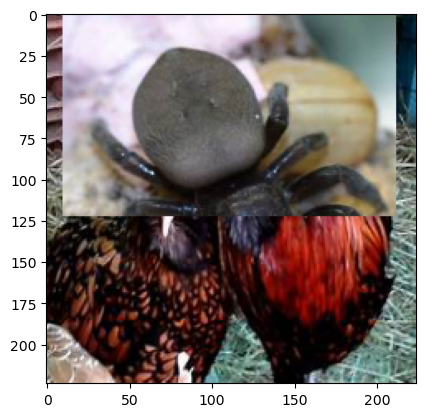

In [208]:
img,label = next(iter(data_loader))
img, label = cut_mix(img,label)
img_p = img.permute(0,2,3,1)
plt.imshow(img_p[0])
print(label[0])


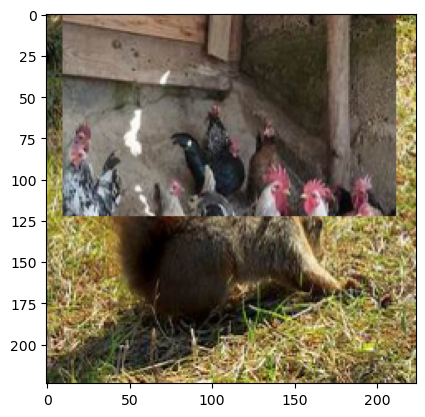

In [209]:
plt.imshow(img_p[2])

In [210]:
class grid_cut_mix():
    #grid_type is in ['grid','horizontal', 'vertical']
    #현재 버전은 dataset 이미지의 해상도가 동일할때 적용 가능
    def __init__(self, num_classes,shape:list,sample_loader, alpha=0.3,grid=3,grid_type='grid',device='cpu'):
        self.alpha = alpha
        self.grid = grid
        self.grid_type = grid_type
        self.num_classes = num_classes
        self.device = device
        self.shape=shape
        if len(shape) != 2:
            raise ValueError("2차원 배열만 사용 가능합니다.")
        horizontal = torch.repeat_interleave(torch.Tensor([True,False]).bool(),grid)
        horizontal = horizontal.repeat((shape[1]+2*grid-1)//(2*grid))[:shape[1]].view(1,-1)
        vertical = torch.repeat_interleave(torch.Tensor([True,False]).bool(),grid)
        vertical = vertical.repeat((shape[1]+2*grid-1)//(2*grid))[:shape[1]].view(-1,1)
        slice_map = torch.zeros(shape,dtype=torch.bool)
        self.sample_loader = iter(sample_loader)
        if grid_type == 'horizontal':
            slice_map[horizontal[0],:]=True
        elif grid_type == 'vertical':
            slice_map[:,vertical[:,0]] = True
        elif grid_type == 'grid':
            slice_map = horizontal*vertical + (~horizontal)*(~vertical)
        self.slice_map = slice_map
        print('slice map shape:',slice_map.shape,horizontal.shape)
    def __call__(self,img,label):
        label = torch.nn.functional.one_hot(label,self.num_classes).float()
        p = torch.rand(img.shape[0]) < self.alpha
        sample_img,sample_label = next(self.sample_loader)
        print(p)
        sample_label = torch.nn.functional.one_hot(sample_label,self.num_classes).float()
        new_sample = img[p]
        target_sample = sample_img[p]
        new_sample[:,:,self.slice_map] = target_sample[:,:,self.slice_map]
        img[p] = new_sample
        label[p] = (label[p]+sample_label[p])/2
        return img,label

In [211]:
sample_loader = DataLoader(dataset,batch_size=4,shuffle=True)

gcm = grid_cut_mix(10,[224,224],sample_loader=sample_loader,alpha=1.,grid=3,grid_type='grid')
# gcm.slice_map.float()

slice map shape: torch.Size([224, 224]) torch.Size([1, 224])


In [212]:
img,label = next(iter(data_loader))
print(img.shape)
img,label = gcm(img,label)

torch.Size([4, 3, 224, 224])
tensor([True, True, True, True])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000])


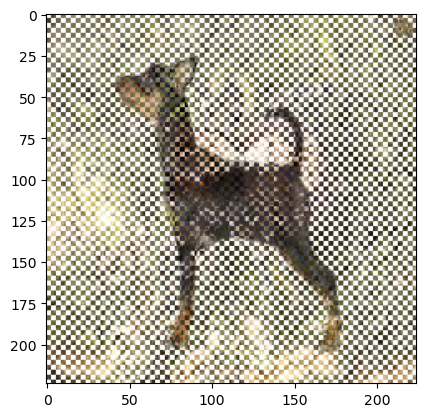

In [214]:

img_p = img.permute(0,2,3,1)
idx=1
plt.imshow(img_p[idx])
print(label[idx])